In [1]:
from sympy import symbols, init_printing
init_printing()
from celmech.hamiltonian import AndoyerHamiltonian
from celmech.transformations import poincare_vars_to_andoyer_vars, poincare_vars_from_sim
from celmech.transformations import jacobi_masses_from_sim, get_andoyer_params
from celmech.transformations import andoyer_vars_to_poincare_vars, andoyer_vars_from_sim
from celmech.transformations import poincare_vars_to_sim, andoyer_vars_to_sim, my_andoyer_vars_to_poincare_vars

SyntaxError: invalid syntax (transformations.py, line 134)

In [2]:
import rebound
import numpy as np

def make_sim(j, k):
    mass = 1.e-5
    e0 = 0.1 # initial eccentricity of planets
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=mass, e=e0, pomega = np.pi/2., P=1., theta=np.pi)
    sim.add(m=2*mass, e=1.e-5, pomega=0., P=j/float(j-k))
    sim.move_to_com()
    return sim

j=7
k=2
sim = make_sim(j,k)

In [3]:
sim = make_sim(j,k)
ps = sim.particles
a10 = ps[1].a
a20 = ps[2].a

andvars, params = andoyer_vars_from_sim(sim, j, k, a10, a20, average_synodic_terms=True)
Phi0, phi0, W0, w0, B0, K0, deltalambda0, lambda10 = andvars
Phiscale, timescale, Phiprime = params
Hsim = AndoyerHamiltonian(k, Phiprime, Phi0, phi0)

Norbits = 3000
Nout = 1000
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)
symtimes = times/abs(timescale)

Nsol = np.zeros((2, Nout))
symsol = np.zeros((2, Nout))
pratio, BrouwerErr, WErr, Ks = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
Ws, ws = np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    pratio[i] = ps[2].P/ps[1].P
    andvars, params = andoyer_vars_from_sim(sim, j, k, a10, a20, average_synodic_terms=True)
    Phi, phi, W, w, B, K, deltalambda, lambda1 = andvars
    BrouwerErr[i] = abs((B-B0)/B0)
    WErr[i] = abs((W-W0)/W0)
    Ks[i] = K
    Ws[i] = W
    ws[i] = w

    symsol[:,i] = [Hsim.y['Phi'], Hsim.y['phi']]
    Nsol[:,i] = [Phi, phi]

    sim.integrate(np.sign(timescale)*time)    
    Hsim.integrate(symtimes[i])

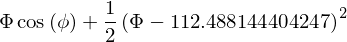

In [4]:
Hsim.NH

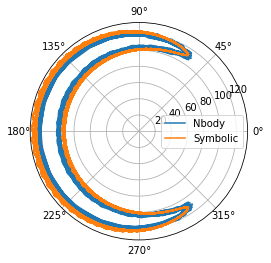

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.subplot('111', projection='polar')
ax.plot(Nsol[1,:], Nsol[0,:], label='Nbody')
ax.plot(symsol[1,:], symsol[0,:], label='Symbolic')
ax.legend()

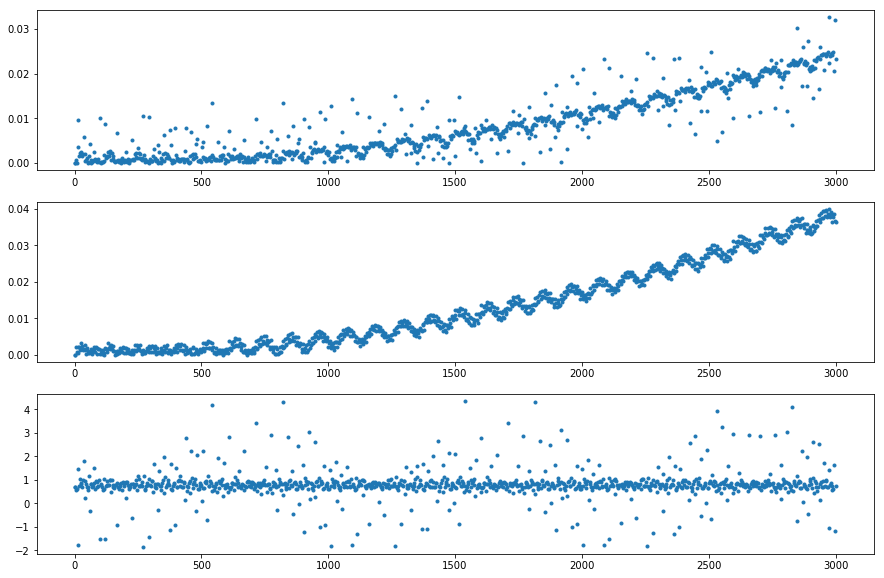

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(figsize=(15,10), nrows=3)
axarr[0].plot(times, BrouwerErr, '.')
axarr[1].plot(times, WErr, '.')
axarr[2].plot(times, Ks, '.')

In [7]:
sim = make_sim(j,k)
ps = sim.particles
a10 = ps[1].a
a20 = ps[2].a

andvars, params = andoyer_vars_from_sim(sim, j, k, a10, a20, average_synodic_terms=True)
Phi0, phi0, W0, w0, B0, K0, A0, B0, C0 = andvars
Phiscale, timescale, Phiprime = params

In [8]:
andvars

In [3]:
sim = make_sim(j,k)
pvars = poincare_vars_from_sim(sim)
pvars

In [4]:
sim2 = poincare_vars_to_sim(pvars, 4*np.pi**2, [1,1.e-5, 2.e-5])

In [5]:
sim.status()

---------------------------------
REBOUND version:     	3.5.2
REBOUND built on:    	Jun 19 2017 06:06:25
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=-1.5128614120704468e-05 y=-1.2123922485543604e-21 z=0.0 vx=6.314796735421821e-06 vy=-4.9182140527878164e-05 vz=0.0>
<rebound.Particle object, m=1e-05 x=-0.9900184286031207 y=1.2123922485543603e-16 z=0.0 vx=-0.6314796735421822 vy=-6.314909065529696 vz=0.0>
<rebound.Particle object, m=2e-05 x=1.2514399203367836 y=0.0 z=0.0 vx=0.0 vy=5.616561559158756 vz=0.0>
---------------------------------


In [6]:
sim2.status()

---------------------------------
REBOUND version:     	3.5.2
REBOUND built on:    	Jun 19 2017 06:06:25
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=1.0 x=-1.5128614120694105e-05 y=9.858346853816481e-22 z=0.0 vx=6.31479673542181e-06 vy=-4.918214052792464e-05 vz=0.0>
<rebound.Particle object, m=1e-05 x=-0.990018428603121 y=-9.85834685381648e-17 z=0.0 vx=-0.631479673542181 vy=-6.314909065529696 vz=0.0>
<rebound.Particle object, m=2e-05 x=1.2514399203362656 y=0.0 z=0.0 vx=0.0 vy=5.61656155916108 vz=0.0>
---------------------------------


In [3]:
sim = make_sim(j,k)
pvars = poincare_vars_from_sim(sim)
pvars

In [4]:
ps = sim.particles
a10 = ps[1].a
a20 = ps[2].a
andvars, coeff = poincare_vars_to_andoyer_vars(pvars, sim.G, ps[0].m, ps[1].m, ps[2].m, j, k, a10, a20)
andvars

In [5]:
pvars2 = andoyer_vars_to_poincare_vars(andvars, sim.G, ps[0].m, ps[1].m, ps[2].m, ps[1].n, ps[2].n, j, k, a10, a20)

In [6]:
pvars2

In [7]:
pvars3 = my_andoyer_vars_to_poincare_vars(andvars, sim.G, [p.m for p in ps], a10, a20, j, k)

In [8]:
pvars3

In [14]:
a = np.array([2,3])
b = np.array([3,4])
a*b

array([ 6, 12])

In [15]:
a*np.array(4)

array([ 8, 12])

In [19]:
from numpy.linalg import norm
norm(a)

In [20]:
np.sqrt(4+9)

In [2]:
import rebound
import numpy as np

def make_sim(j, k):
    mass = 1.e-12
    e0 = 0.1 # initial eccentricity of planets
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=mass, e=e0, pomega = np.pi/2., P=1., l=np.pi)
    sim.add(m=2*mass, e=1.e-5, pomega=0., P=j/float(j-k), l=0)
    sim.move_to_com()
    return sim

j=7
k=2
sim = make_sim(j,k)
ps = sim.particles

In [3]:
sim = make_sim(j,k)
ps = sim.particles
a10 = ps[1].a
a20 = ps[2].a

andvars, params = andoyer_vars_from_sim(sim, j, k, a10, a20, average_synodic_terms=True)
Phi0, phi0, W0, w0, B0, K0, deltalambda0, lambda10 = andvars
Phiscale, timescale, Phiprime = params
Hsim = AndoyerHamiltonian(k, Phiprime, Phi0, phi0)

Norbits = 3000
Nout = 1000
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)
symtimes = times/abs(timescale)

Nsol = np.zeros((2, Nout))
symsol = np.zeros((2, Nout))
pratio, BrouwerErr, WErr, Ks = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
Ws, ws = np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    pratio[i] = ps[2].P/ps[1].P
    andvars, params = andoyer_vars_from_sim(sim, j, k, a10, a20, average_synodic_terms=True)
    Phi, phi, W, w, B, K, deltalambda, lambda1 = andvars
    BrouwerErr[i] = abs((B-B0)/B0)
    WErr[i] = abs((W-W0)/W0)
    Ks[i] = K
    Ws[i] = W
    ws[i] = w

    symsol[:,i] = [Hsim.y['Phi'], Hsim.y['phi']]
    Nsol[:,i] = [Phi, phi]

    sim.integrate(np.sign(timescale)*time)    
    Hsim.integrate(symtimes[i])

9.58638658775e-15
-1.21929935593e+14 1.16886749911 -1.03857609326e-09 4.11535484638e+12
9.58638658775e-15
-1.21929935593e+14 1.16886749911 -1.03857609326e-09 4.11535484638e+12
9.58638658775e-15
-1.21929935593e+14 1.16886749911 -1.03857609326e-09 4.11535484638e+12
9.58638658773e-15
-1.21929935593e+14 1.16886749911 -1.03857609326e-09 4.11535484638e+12
9.58638658697e-15
-1.21929935593e+14 1.16886749905 -1.03857609326e-09 4.11535484638e+12
9.58638659007e-15
-1.21929935593e+14 1.16886749987 -1.03857609326e-09 4.11535484638e+12
9.58638658652e-15
-1.21929935593e+14 1.1688674987 -1.03857609326e-09 4.11535484638e+12
9.58638658847e-15
-1.21929935593e+14 1.16886749918 -1.03857609326e-09 4.11535484638e+12
9.58638658767e-15
-1.21929935593e+14 1.16886749911 -1.03857609326e-09 4.11535484638e+12
9.58638658769e-15
-1.21929935593e+14 1.16886749911 -1.03857609326e-09 4.11535484638e+12
9.58638658766e-15
-1.21929935593e+14 1.1688674991 -1.03857609326e-09 4.11535484638e+12
9.58638658695e-15
-1.21929935593e+

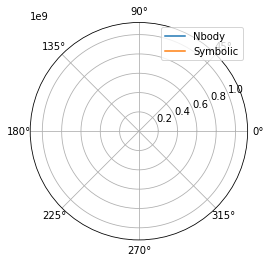

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.subplot('111', projection='polar')
ax.plot(Nsol[1,:], Nsol[0,:], label='Nbody')
ax.plot(symsol[1,:], symsol[0,:], label='Symbolic')
ax.legend()